# Introduction to DataFrames
**[Bogumił Kamiński](http://bogumilkaminski.pl/about/), May 15, 2021**

In [1]:
using DataFrames

## Load and save DataFrames
We do not cover all features of the packages. Please refer to their documentation to learn them.

Here we'll load CSV.jl to read and write CSV files and Arrow.jl, JLSO.jl, and serialization, which allow us to work with a binary format and JSONTables.jl for JSON interaction. Finally we consider a custom JDF.jl format.

In [2]:
using Arrow
using CSV
using Serialization
using JLSO
using JSONTables
using CodecZlib
using ZipFile
using JDF
using StatsPlots # for charts
using Mmap # for compression

Let's create a simple `DataFrame` for testing purposes,

In [3]:
x = DataFrame(A=[true, false, true], B=[1, 2, missing],
              C=[missing, "b", "c"], D=['a', missing, 'c'])

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


and use `eltypes` to look at the columnwise types.

In [4]:
eltype.(eachcol(x))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### CSV.jl

Let's use `CSV` to save `x` to disk; make sure `x1.csv` does not conflict with some file in your working directory.

In [5]:
CSV.write("x1.csv", x)

"x1.csv"

Now we can see how it was saved by reading `x.csv`.

In [6]:
print(read("x1.csv", String))

A,B,C,D
true,1,,a
false,2,b,
true,,c,c


We can also load it back.

In [7]:
y = CSV.read("x1.csv", DataFrame)

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


Note that when loading in a `DataFrame` from a `CSV` the column type for column `:D` has changed!

In [8]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Serialization, JDF.jl, and JLSO.jl

#### Serialization

Now we use serialization to save `x`.

There are two ways to perform serialization. The first way is to use the `Serialization.serialize` as below:

Note that in general, this process will not work if the reading and writing are done by different versions of Julia, or an instance of Julia with a different system image.

In [9]:
open("x.bin", "w") do io
    serialize(io, x)
end

Now we load back the saved file to `y` variable. Again `y` is identical to `x`. However, please beware that if you session does not have DataFrames.jl loaded, then it may not recognise the content as DataFrames.jl

In [10]:
y = open(deserialize, "x.bin")

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [11]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

#### JDF.jl

[JDF.jl](https://github.com/xiaodaigh/JDF) is a relatively new package designed to serialize DataFrames. You can save a DataFrame with the `savejdf` function.

In [12]:
JDF.save("x.jdf", x);

To load the saved JDF file, one can use the `loadjdf` function

In [13]:
x_loaded = JDF.load("x.jdf") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


You can see that they are the same

In [14]:
isequal(x_loaded, x)

true

JDF.jl offers the ability to load only certain columns from disk to help with working with large files

In [15]:
# set up a JDFFile which is a on disk representation of `x` backed by JDF.jl
x_ondisk = jdf"x.jdf"

JDFFile{String}("x.jdf")

We can see all the names of `x` without loading it into memory

In [16]:
names(x_ondisk)

4-element Vector{Symbol}:
 :A
 :B
 :C
 :D

The below is an example of how to load only columns `:A` and `:D` 

In [17]:
xd = JDF.load(x_ondisk; cols = ["A", "D"]) |> DataFrame

,A,D
,Bool,Char?
1,1,a
2,0,missing
3,1,c


##### JDF.jl vs others

For more details about design assumptions and limitations of JDF.jl check out https://github.com/xiaodaigh/JDF.jl.

#### JLSO.jl

Another way to perform serialization is by using the [JLSO.jl](https://github.com/invenia/JLSO.jl) library:

In [18]:
JLSO.save("x.jlso", :data => x)

Now we can laod back the file to `y`

In [19]:
y = JLSO.load("x.jlso")[:data]

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [20]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

### JSONTables.jl

Often you might need to read and write data stored in JSON format. JSONTables.jl provides a way to process them in row-oriented or column-oriented layout. We present both options below.

In [21]:
open(io -> arraytable(io, x), "x1.json", "w")

106

In [22]:
open(io -> objecttable(io, x), "x2.json", "w")

76

In [23]:
print(read("x1.json", String))

[{"A":true,"B":1,"C":null,"D":"a"},{"A":false,"B":2,"C":"b","D":null},{"A":true,"B":null,"C":"c","D":"c"}]

In [24]:
print(read("x2.json", String))

{"A":[true,false,true],"B":[1,2,null],"C":[null,"b","c"],"D":["a",null,"c"]}

In [25]:
y1 = open(jsontable, "x1.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [26]:
eltype.(eachcol(y1))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

In [27]:
y2 = open(jsontable, "x2.json") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,String?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [28]:
eltype.(eachcol(y2))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, String}

### Arrow.jl

Finally we use Apache Arrow format that allows, in particular, for data interchange with R or Python.

In [29]:
Arrow.write("x.arrow", x)

"x.arrow"

In [30]:
y = Arrow.Table("x.arrow") |> DataFrame

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [31]:
eltype.(eachcol(y))

4-element Vector{Type}:
 Bool
 Union{Missing, Int64}
 Union{Missing, String}
 Union{Missing, Char}

Note that columns of `y` are immutable

In [32]:
y.A[1] = false

LoadError: ReadOnlyMemoryError()

This is because `Arrow.Table` uses memory mapping and thus uses a custom vector types:

In [33]:
y.A

3-element Arrow.BoolVector{Bool}:
 1
 0
 1

In [34]:
y.B

3-element Arrow.Primitive{Union{Missing, Int64}, Vector{Int64}}:
 1
 2
  missing

You can get standard Julia Base vectors by copying a data frame

In [35]:
y2 = copy(y)

,A,B,C,D
,Bool,Int64?,String?,Char?
1,1,1,missing,a
2,0,2,b,missing
3,1,missing,c,c


In [36]:
y2.A

3-element Vector{Bool}:
 1
 0
 1

In [37]:
y2.B

3-element Vector{Union{Missing, Int64}}:
 1
 2
  missing

### Basic bechmarking

Next, we'll create some files, so be careful that you don't already have these files in your working directory!

In particular, we'll time how long it takes us to write a `DataFrame` with 10^3 rows and 10^5 columns.

In [38]:
bigdf = DataFrame(rand(Bool, 10^5, 1000), :auto)
bigdf[!, 1] = Int.(bigdf[!, 1])
bigdf[!, 2] = bigdf[!, 2] .+ 0.5
bigdf[!, 3] = string.(bigdf[!, 3], ", as string")
println("First run")
println("CSV.jl")
csvwrite1 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite1 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite1 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite1 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite1 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite1 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite1 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")
println("Second run")
println("CSV.jl")
csvwrite2 = @elapsed @time CSV.write("bigdf1.csv", bigdf)
println("Serialization")
serializewrite2 = @elapsed @time open(io -> serialize(io, bigdf), "bigdf.bin", "w")
println("JDF.jl")
jdfwrite2 = @elapsed @time JDF.save("bigdf.jdf", bigdf)
println("JLSO.jl")
jlsowrite2 = @elapsed @time JLSO.save("bigdf.jlso", :data => bigdf)
println("Arrow.jl")
arrowwrite2 = @elapsed @time Arrow.write("bigdf.arrow", bigdf)
println("JSONTables.jl arraytable")
jsontablesawrite2 = @elapsed @time open(io -> arraytable(io, bigdf), "bigdf1.json", "w")
println("JSONTables.jl objecttable")
jsontablesowrite2 = @elapsed @time open(io -> objecttable(io, bigdf), "bigdf2.json", "w")

First run
CSV.jl
 56.471228 seconds (598.96 M allocations: 17.921 GiB, 4.25% gc time, 9.18% compilation time)
Serialization
  3.359629 seconds (424.62 k allocations: 21.356 MiB, 0.89% compilation time)
JDF.jl
  0.874687 seconds (68.72 k allocations: 323.690 MiB, 2.26% gc time, 6.98% compilation time)
JLSO.jl
 10.418325 seconds (329.11 k allocations: 47.314 MiB, 0.67% compilation time)
Arrow.jl
  4.977910 seconds (9.61 M allocations: 658.859 MiB, 2.25% gc time, 81.83% compilation time)
JSONTables.jl arraytable
151.452857 seconds (2.30 G allocations: 54.624 GiB, 6.20% gc time, 0.17% compilation time)
JSONTables.jl objecttable
  3.184260 seconds (321.70 k allocations: 3.087 GiB, 3.18% gc time, 8.92% compilation time)
Second run
CSV.jl
 56.636512 seconds (597.48 M allocations: 17.848 GiB, 4.27% gc time)
Serialization
  3.291138 seconds (106.79 k allocations: 2.320 MiB, 0.87% compilation time)
JDF.jl
  0.912649 seconds (32.65 k allocations: 321.643 MiB, 10.77% gc time)
JLSO.jl
 10.659159 se

3.652594979

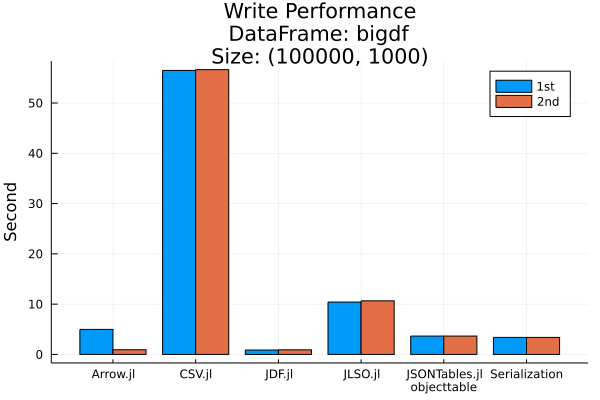

In [39]:
groupedbar(
    # Exclude JSONTables.jl arraytable due to timing
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "JSONTables.jl\nobjecttable"],
            inner = 2),
    [csvwrite1, csvwrite2, serializewrite1, serializewrite1, jdfwrite1, jdfwrite2,
     jlsowrite1, jlsowrite2, arrowwrite1, arrowwrite2, jsontablesowrite2, jsontablesowrite2],
    group = repeat(["1st", "2nd"], outer = 6),
    ylab = "Second",
    title = "Write Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

In [40]:
data_files = ["bigdf1.csv", "bigdf.bin", "bigdf.arrow", "bigdf1.json", "bigdf2.json"]
df = DataFrame(file = data_files, size = getfield.(stat.(data_files), :size))
append!(df, DataFrame(file = "bigdf.jdf", size=reduce((x,y)->x+y.size,
                                                      stat.(joinpath.("bigdf.jdf", readdir("bigdf.jdf"))),
                                                      init=0)))
sort!(df, :size)

,file,size
,String,Int64
1,bigdf.arrow,16151826
2,bigdf.jdf,51251915
3,bigdf.bin,51772454
4,bigdf1.csv,550809910
5,bigdf2.json,550813911
6,bigdf1.json,1240305018


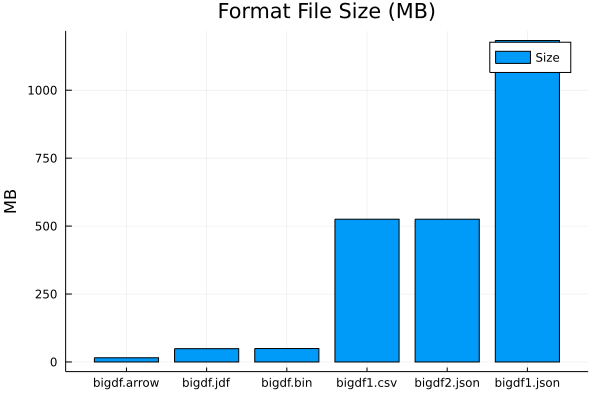

In [41]:
@df df plot(:file, :size/1024^2, seriestype=:bar, title = "Format File Size (MB)", label="Size", ylab="MB")

In [42]:
println("First run")
println("CSV.jl")
csvread1 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread1 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread1 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread1 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread1 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread1copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread1 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread1 = @elapsed @time open(jsontable, "bigdf2.json")
println("Second run")
csvread2 = @elapsed @time CSV.read("bigdf1.csv", DataFrame)
println("Serialization")
serializeread2 = @elapsed @time open(deserialize, "bigdf.bin")
println("JDF.jl")
jdfread2 = @elapsed @time JDF.load("bigdf.jdf") |> DataFrame
println("JLSO.jl")
jlsoread2 = @elapsed @time JLSO.load("bigdf.jlso")
println("Arrow.jl")
arrowread2 = @elapsed @time df_tmp = Arrow.Table("bigdf.arrow") |> DataFrame
arrowread2copy = @elapsed @time copy(df_tmp)
println("JSONTables.jl arraytable")
jsontablesaread2 = @elapsed @time open(jsontable, "bigdf1.json")
println("JSONTables.jl objecttable")
jsontablesoread2 = @elapsed @time open(jsontable, "bigdf2.json");

First run
CSV.jl
  5.801260 seconds (1.04 M allocations: 376.317 MiB, 2.21% gc time, 13.22% compilation time)
Serialization
  6.196458 seconds (99.32 M allocations: 1.576 GiB, 3.22% gc time, 0.47% compilation time)
JDF.jl
  2.038214 seconds (319.99 k allocations: 328.358 MiB, 3.41% gc time, 42.43% compilation time)
JLSO.jl
  4.124939 seconds (99.42 M allocations: 1.594 GiB, 5.08% gc time, 1.11% compilation time)
Arrow.jl
  0.419805 seconds (457.33 k allocations: 26.418 MiB, 36.79% compilation time)
  1.021027 seconds (103.50 k allocations: 101.360 MiB)
JSONTables.jl arraytable
115.616470 seconds (2.40 M allocations: 12.958 GiB, 1.50% gc time, 0.00% compilation time)
JSONTables.jl objecttable
  7.944588 seconds (55.03 k allocations: 2.791 GiB, 9.84% gc time, 1.21% compilation time)
Second run
  6.303223 seconds (13.69 k allocations: 309.298 MiB)
Serialization
  7.584395 seconds (99.30 M allocations: 1.575 GiB, 2.72% gc time)
JDF.jl
  1.481235 seconds (77.22 k allocations: 315.906 MiB)
J

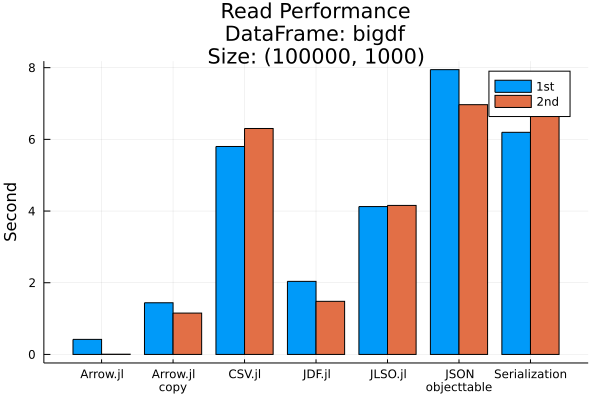

In [59]:
# Exclude JSON\narraytable arraytable due to much longer timing
groupedbar(
    repeat(["CSV.jl", "Serialization", "JDF.jl", "JLSO.jl", "Arrow.jl", "Arrow.jl\ncopy", #"JSON\narraytable",
            "JSON\nobjecttable"], inner = 2),
    [csvread1, csvread2, serializeread1, serializeread2, jdfread1, jdfread2, jlsoread1, jlsoread2,
     arrowread1, arrowread2, arrowread1+arrowread1copy, arrowread2+arrowread2copy,
     # jsontablesaread1, jsontablesaread2,
     jsontablesoread1, jsontablesoread2],    
    group = repeat(["1st", "2nd"], outer = 7),
    ylab = "Second",
    title = "Read Performance\nDataFrame: bigdf\nSize: $(size(bigdf))"
)

### Using gzip compression

A common user requirement is to be able to load and save CSV that are compressed using gzip.
Below we show how this can be accomplished using CodecZlib.jl.
The same pattern is applicable to JSONTables.jl compression/decompression.

Again make sure that you do not have file named `df_compress_test.csv.gz` in your working directory

We first generate a random data frame

In [44]:
df = DataFrame(rand(1:10, 10, 1000), :auto)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,6,3,2,9,7,2,1,1,5,1,8
2,9,1,9,5,4,8,6,9,8,4,4,4
3,8,1,10,2,8,5,1,9,8,4,8,2
4,10,9,6,6,1,6,6,2,8,1,5,2
5,1,6,7,5,7,5,3,6,10,1,3,4
6,4,9,7,10,8,6,1,3,8,8,7,7
7,4,9,3,2,5,5,8,7,9,6,9,7
8,7,7,2,4,6,6,2,5,6,8,7,7
9,4,6,3,8,2,7,2,6,2,2,4,2


In [45]:
# GzipCompressorStream comes from CodecZlib

open("df_compress_test.csv.gz", "w") do io
    stream = GzipCompressorStream(io)
    CSV.write(stream, df)
    close(stream)
end

In [46]:
df2 = CSV.File(transcode(GzipDecompressor, Mmap.mmap("df_compress_test.csv.gz"))) |> DataFrame

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,6,3,2,9,7,2,1,1,5,1,8
2,9,1,9,5,4,8,6,9,8,4,4,4
3,8,1,10,2,8,5,1,9,8,4,8,2
4,10,9,6,6,1,6,6,2,8,1,5,2
5,1,6,7,5,7,5,3,6,10,1,3,4
6,4,9,7,10,8,6,1,3,8,8,7,7
7,4,9,3,2,5,5,8,7,9,6,9,7
8,7,7,2,4,6,6,2,5,6,8,7,7
9,4,6,3,8,2,7,2,6,2,2,4,2


In [47]:
df == df2

true

### Using zip files

Sometimes you may have files compressed inside a zip file.

In such a situation you may use [ZipFile.jl](https://github.com/fhs/ZipFile.jl) in conjunction an an appropriate reader to read the files.

Here we first create a ZIP file and then read back its contents into a `DataFrame`.

In [48]:
df1 = DataFrame(rand(1:10, 3, 4), :auto)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,7,6,7,9
2,3,4,1,1
3,8,7,8,3


In [49]:
df2 = DataFrame(rand(1:10, 3, 4), :auto)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,4,7,2,8
2,3,9,10,2
3,4,5,9,3


And we show yet another way to write a `DataFrame` into a CSV file

In [50]:
# write a CSV file into the zip file
w = ZipFile.Writer("x.zip")

f1 = ZipFile.addfile(w, "x1.csv")
write(f1, sprint(show, "text/csv", df1))

# write a second CSV file into zip file
f2 = ZipFile.addfile(w, "x2.csv", method=ZipFile.Deflate)
write(f2, sprint(show, "text/csv", df2))

close(w)

Now we read the CSV we have written:

In [51]:
z = ZipFile.Reader("x.zip");

In [52]:
# find the index index of file called x1.csv
index_xcsv = findfirst(x->x.name == "x1.csv", z.files)
# to read the x1.csv file in the zip file
df1_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,7,6,7,9
2,3,4,1,1
3,8,7,8,3


In [53]:
df1_2 == df1

true

In [54]:
# find the index index of file called x2.csv
index_xcsv = findfirst(x->x.name == "x2.csv", z.files)
# to read the x2.csv file in the zip file
df2_2 = CSV.read(read(z.files[index_xcsv]), DataFrame)

,x1,x2,x3,x4
,Int64,Int64,Int64,Int64
1,4,7,2,8
2,3,9,10,2
3,4,5,9,3


In [55]:
df2_2 == df2

true

Note that once you read a given file from `z` object its stream is all used-up (it is at its end). Therefore to read it again you need to close `z` and open it again.

Also do not forget to close the zip file once done.

In [56]:
close(z)

Finally, let's clean up. Do not run the next cell unless you are sure that it will not erase your important files.

In [57]:
foreach(rm, ["x1.csv", "x.bin", "x.jlso", "x1.json", "x2.json",
             "bigdf1.csv", "bigdf.bin", "bigdf.jlso", "bigdf1.json", "bigdf2.json", 
             "x.zip"])

In [58]:
rm("bigdf.jdf", recursive=true)
rm("x.jdf", recursive=true)

Note that we did not remove `x.arrow` and `bigdf.arrow` and `df_compress_test.csv.gz` - you have to do it manually, as these files are memory mapped.